In [ ]:
# %pip install scikit-learn imbalanced-learn==0.11.0
# %pip install matplotlib
# %pip install seaborn
# %pip install mlflow dagshub

In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
import gc
import dagshub
import mlflow

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 15)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

# to ignore warnings in cells
warnings.filterwarnings('ignore')

In [5]:
random_state = 42

def show_na_means(df):
  na_means = df.isna().mean().sort_values(ascending=False)
  print(na_means[na_means > 0])

def get_cat_num_cols(df):
  cat_cols = [col for col in df.columns if df[col].dtype == 'object']
  num_cols = [col for col in df.columns if df[col].dtype != 'object']
  return (cat_cols, num_cols)

In [6]:
df_train_transaction = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")
df_train_identity = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_identity.csv")

In [7]:
df_train_transaction.shape, df_train_identity.shape

((590540, 394), (144233, 41))

In [8]:
df_train = pd.merge(df_train_transaction, df_train_identity, on="TransactionID", how="left")

In [9]:
df_train.shape

(590540, 434)

# Data Inspection

In [10]:
# Inspect NaN percentage for each column.
show_na_means(df_train)

id_24    0.991962
id_25    0.991310
id_07    0.991271
id_08    0.991271
id_21    0.991264
           ...   
V316     0.000020
V317     0.000020
V318     0.000020
V319     0.000020
V310     0.000020
Length: 414, dtype: float64


In [11]:
# Inspect the target variable distribution.
df_train['isFraud'].value_counts(normalize=True)

isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64

In [12]:
# Inspect number of transactions with/without `TransactionID`, how much of them are fraud and non-fraud.
has_id = df_train_transaction["TransactionID"].isin(df_train_identity["TransactionID"])
has_not_id = ~has_id

df_has_id = df_train_transaction[has_id]
df_has_not_id = df_train_transaction[has_not_id]

with_id = df_has_id["isFraud"].value_counts(normalize=True)
without_id = df_has_not_id["isFraud"].value_counts(normalize=True)

print("With TransactionID:")
print(with_id)
print(f'Total: {df_has_id.shape[0]}')
print()
print("Without TransactionID:")
print(without_id)
print(f'Total: {df_has_not_id.shape[0]}')


# cleanup
del with_id
del without_id
del df_has_id
del df_has_not_id
del has_id
del has_not_id

gc.collect()

With TransactionID:
isFraud
0    0.92153
1    0.07847
Name: proportion, dtype: float64
Total: 144233

Without TransactionID:
isFraud
0    0.979061
1    0.020939
Name: proportion, dtype: float64
Total: 446307


0

# Train/Test Split

In [13]:
X_train, X_test = train_test_split(df_train, test_size=0.2, random_state=random_state)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = X_train.pop('isFraud')
y_test = X_test.pop('isFraud')

In [14]:
show_na_means(X_train)

id_24    0.991933
id_25    0.991292
id_08    0.991250
id_07    0.991250
id_21    0.991241
           ...   
V310     0.000023
V318     0.000023
V317     0.000023
V319     0.000023
V311     0.000023
Length: 414, dtype: float64


In [15]:
show_na_means(X_test)

id_24    0.992075
id_25    0.991381
id_07    0.991355
id_08    0.991355
id_21    0.991355
           ...   
V310     0.000008
V318     0.000008
V317     0.000008
V319     0.000008
V311     0.000008
Length: 414, dtype: float64


In [16]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((472432, 433), (472432,), (118108, 433), (118108,))

In [17]:
len(y_test[y_test == 1]) / len(y_test), len(y_train[y_train == 1]) / len(y_train)

(0.035916280014901616, 0.03475844142649101)

# Preprocessing

## Handling NaNs

In [18]:
class SimpleNAPreprocessor(BaseEstimator, TransformerMixin):
  """Fills NaNs with mode for categorical columns and with median for numerical columns."""

  def __init__(self):
    super().__init__()

  def fit(self, X, y):
    X_work = X.copy()

    self.cat_cols, self.num_cols = get_cat_num_cols(X_work)

    self.cat_cols_modes = {}
    for catcol in self.cat_cols:
      self.cat_cols_modes[catcol] = X_work[catcol].mode().iloc[0]
    
    self.num_cols_medians = {}
    for numcol in self.num_cols:
      self.num_cols_medians[numcol] = X_work[numcol].median()
    
    return self

  def transform(self, X):
    X_work = X.copy()

    # fill categorical missing values with mode
    for catcol in self.cat_cols:
      X_work.fillna({catcol: self.cat_cols_modes[catcol]}, inplace=True)

    # fill numerical missing values with median
    for numcol in self.num_cols:
      X_work.fillna({numcol: self.num_cols_medians[numcol]}, inplace=True)

    return X_work

In [19]:
simple_na_preprocessor = SimpleNAPreprocessor()

X_train_na = simple_na_preprocessor.fit_transform(X_train, y_train)
X_test_na = simple_na_preprocessor.transform(X_test)

del simple_na_preprocessor

gc.collect()

0

In [20]:
X_train_na.isna().any().sum(), X_test_na.isna().any().sum()

(0, 0)

## Categoric to Numeric Conversions

In [21]:
class EncoderPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, onehot_threshold: int):
        self.onehot_threshold = onehot_threshold

    def fit(self, X, y):
        cat_cols, _ = get_cat_num_cols(X)

        nuniques = X[cat_cols].nunique()
        self.onehot_columns = list(nuniques[nuniques <= self.onehot_threshold].index)
        self.woe_columns = list(nuniques[nuniques > self.onehot_threshold].index)

        self.woe_columns_fill_na = X[self.woe_columns].mode().T[0].to_dict()

        df_woe = X.copy()
        target_col = 'target'
        df_woe[target_col] = y

        self.woe_mappings = {}
        self.iv_values = {}
        
        for col in self.woe_columns:
            groups = df_woe.groupby([col])[target_col].agg(['count', 'sum'])
            groups.columns = ['n_obs', 'n_pos']
            groups['n_neg'] = groups['n_obs'] - groups['n_pos']
      
            groups['prop_pos'] = groups['n_pos'] / groups['n_pos'].sum()
            groups['prop_neg'] = groups['n_neg'] / groups['n_neg'].sum()
      
            groups['woe'] = np.log(groups['prop_pos'] / groups['prop_neg'])
            groups['iv'] = (groups['prop_pos'] - groups['prop_neg']) * groups['woe']
      
            groups.replace([np.inf, -np.inf], 0, inplace=True)
            groups.fillna(0, inplace=True)
      
            woe_dict = groups['woe'].to_dict()
            iv = groups['iv'].sum()
      
            self.woe_mappings[col] = woe_dict
            self.iv_values[col] = iv

        # store expected onehot columns
        df_onehot = pd.get_dummies(X[self.onehot_columns], columns=self.onehot_columns, drop_first=True, dummy_na=True, dtype=int)
        self.expected_onehot_columns = df_onehot.columns.tolist()

        return self

    def transform(self, X):
        X_work = X.copy()

        # Preprocess WOE Columns
        for col in self.woe_columns:
            X_work[f'{col}_woe'] = X_work[col].map(self.woe_mappings[col])
            X_work.drop(columns=col, inplace=True)
        
        # apply One-Hot Encoding
        df_dummy = pd.get_dummies(X_work, columns=self.onehot_columns, drop_first=True, dummy_na=True, dtype=int)

        # categories in train but not in test
        missing_cols = set(self.expected_onehot_columns) - set(df_dummy.columns)
        for col in missing_cols:
            df_dummy[col] = 0
        
        # categories in test but not in train
        extra_cols = set(df_dummy.columns) - set(self.expected_onehot_columns) - set(X_work.columns)
        if extra_cols:
            df_dummy = df_dummy.drop(columns=list(extra_cols))

        # maintain order
        common_cols = list(set(X_work.columns) - set(self.onehot_columns))
        X_work = df_dummy[common_cols + self.expected_onehot_columns]

        n = X_work.isna().mean()

        na_cols = list(n[n > 0].index)
        print(na_cols)

        for col in na_cols:
            col_splitted = col.split("_")
            pr = col_splitted[-1]
            name = '_'.join(col_splitted[:-1])
            if pr != "woe":
                print(col)
                print("Error Related to Nans")

            dic = self.woe_columns_fill_na
            mappings = self.woe_mappings
            X_work[col] = X_work[col].fillna(mappings[name][dic[name]])

        return X_work

In [22]:
encoder_preprocessor = EncoderPreprocessor(onehot_threshold=3)

X_train_num = encoder_preprocessor.fit_transform(X_train_na, y_train)
X_test_num = encoder_preprocessor.transform(X_test_na)

[]
['DeviceInfo_woe', 'id_31_woe', 'id_33_woe']


In [23]:
X_train_num.isna().any().sum(), X_test_num.isna().any().sum()

(0, 0)

In [24]:
X_train_num.shape, X_test_num.shape

((472432, 457), (118108, 457))

## Correlation Filter

In [25]:
class CorrelationFilterPreprocessor(BaseEstimator, TransformerMixin):
  """Removes WoE-encoded features with correlation higher than given threshold."""

  def __init__(self, correlation_threshold: float):
    self.correlation_threshold = correlation_threshold
  
  def fit(self, X, y):
    X_work = X.copy()

    woe_columns = [col for col in X_work.columns if 'woe' in col]

    correlation_columns = list(set(woe_columns))
    print(correlation_columns)

    X_work = X_work[correlation_columns]

    corr_matrix = X_work.corr().abs()
    pairs = []

    for i in range(len(corr_matrix.columns)):
      for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > self.correlation_threshold:
          col_i = corr_matrix.columns[i]
          col_j = corr_matrix.columns[j]

          pairs.append((col_i, col_j, corr_matrix.iloc[i, j]))
    
    temp_target_name = 'isFraud'
    X_work[temp_target_name] = y

    # sort by correlation coefficients
    pairs.sort(key=lambda x: x[2], reverse=True)

    # print(pairs)
    
    self.features_to_drop = set()
    for feat1, feat2, _ in pairs:
      if feat1 in self.features_to_drop or feat2 in self.features_to_drop:
        # if one of them was already marked
        continue
      
      if abs(X_work[feat1].corr(X_work[temp_target_name])) < abs(X_work[feat2].corr(X_work[temp_target_name])):
        self.features_to_drop.add(feat1)
      else:
        self.features_to_drop.add(feat2)
    
    print(f'Dropping total of {len(self.features_to_drop)} features: {self.features_to_drop}')
    
    return self

  def transform(self, X):
    X_work = X.copy()

    X_work.drop(list(self.features_to_drop), axis=1, inplace=True)

    # print(f'Final number of features: {len(X_work.columns)}')

    return X_work

In [26]:
correlation_filter_preprocessor = CorrelationFilterPreprocessor(correlation_threshold=0.8)

X_train_uncorrelated = correlation_filter_preprocessor.fit_transform(X_train_num, y_train)
X_test_uncorrelated = correlation_filter_preprocessor.transform(X_test_num)

['card6_woe', 'P_emaildomain_woe', 'id_31_woe', 'R_emaildomain_woe', 'card4_woe', 'DeviceInfo_woe', 'id_33_woe', 'id_30_woe', 'id_34_woe', 'ProductCD_woe']
Dropping total of 0 features: set()


In [27]:
X_train_uncorrelated.shape, X_test_uncorrelated.shape

((472432, 457), (118108, 457))

# Training

In [38]:
imb_pipeline = ImbPipeline(steps=[
    ('na_filler', SimpleNAPreprocessor()),
    ('encoder', EncoderPreprocessor(onehot_threshold=3)),
    ('correlation_filter', CorrelationFilterPreprocessor(correlation_threshold=0.8)),
    ('undersampler', RandomUnderSampler(random_state=random_state, sampling_strategy=0.33)),
    ('classifier', LogisticRegression(max_iter=1000))
])

grid_search = GridSearchCV(
    estimator=imb_pipeline,
    param_grid={},
    scoring="roc_auc",
    cv=5
)

grid_search.fit(X_train, y_train)

[]
['card6_woe', 'P_emaildomain_woe', 'id_31_woe', 'R_emaildomain_woe', 'card4_woe', 'DeviceInfo_woe', 'id_33_woe', 'id_30_woe', 'id_34_woe', 'ProductCD_woe']
Dropping total of 0 features: set()
['DeviceInfo_woe', 'id_31_woe', 'id_33_woe']
[]
['card6_woe', 'P_emaildomain_woe', 'id_31_woe', 'R_emaildomain_woe', 'card4_woe', 'DeviceInfo_woe', 'id_33_woe', 'id_30_woe', 'id_34_woe', 'ProductCD_woe']
Dropping total of 0 features: set()
['DeviceInfo_woe', 'id_31_woe', 'id_33_woe']
[]
['card6_woe', 'P_emaildomain_woe', 'id_31_woe', 'R_emaildomain_woe', 'card4_woe', 'DeviceInfo_woe', 'id_33_woe', 'id_30_woe', 'id_34_woe', 'ProductCD_woe']
Dropping total of 0 features: set()
['DeviceInfo_woe', 'id_31_woe', 'id_33_woe']
[]
['card6_woe', 'P_emaildomain_woe', 'id_31_woe', 'R_emaildomain_woe', 'card4_woe', 'DeviceInfo_woe', 'id_33_woe', 'id_30_woe', 'id_34_woe', 'ProductCD_woe']
Dropping total of 0 features: set()
['DeviceInfo_woe', 'id_31_woe', 'id_33_woe']
[]
['card6_woe', 'P_emaildomain_woe', 'i

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('na_filler', SimpleNAPreprocessor()),
                                       ('encoder',
                                        EncoderPreprocessor(onehot_threshold=3)),
                                       ('correlation_filter',
                                        CorrelationFilterPreprocessor(correlation_threshold=0.8)),
                                       ('undersampler',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.33)),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={}, scoring='roc_auc')

# MLFlow Tracking

In [46]:
import dagshub
dagshub.init(repo_owner='b3tameche', repo_name='kaggle-fraud-detection', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=9d0ff10e-7fb1-4218-9b03-e2c8fa56f0a7&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=9f7f1d31f4c62b1c115c518ef2fb00f8e142341007a3f715a52c2662c2501bfa




Output()

Accessing as b3tameche

Initialized MLflow to track repo "b3tameche/kaggle-fraud-detection"

Repository b3tameche/kaggle-fraud-detection initialized!

## Cleaning Phase

In [56]:
# Retrieve cleaning objects
na_filler = grid_search.best_estimator_['na_filler']
encoder = grid_search.best_estimator_['encoder']
correlation_filter = grid_search.best_estimator_['correlation_filter']

In [55]:
experiment_name = "LogReg_Training"
cleaning_run_name = "LogReg_Cleaning"

mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name=cleaning_run_name):
    mlflow.log_param("na_filler_cat_cols_modes", na_filler.cat_cols_modes)
    mlflow.log_param("na_filler_num_cols_medians", na_filler.num_cols_medians)

    mlflow.log_param("encoder_woe_columns", encoder.woe_columns)
    mlflow.log_param("encoder_onehot_columns", encoder.onehot_columns)
    mlflow.log_param("encoder_expected_onehot_columns", encoder.expected_onehot_columns)

    mlflow.log_param("correlation_filter_features_to_drop", correlation_filter.features_to_drop)

2025/04/21 11:03:41 INFO mlflow.tracking.fluent: Experiment with name 'LogReg_Training' does not exist. Creating a new experiment.


🏃 View run LogReg_Cleaning at: https://dagshub.com/b3tameche/kaggle-fraud-detection.mlflow/#/experiments/1/runs/094c332a571d4522bf1758ce2d70c38b
🧪 View experiment at: https://dagshub.com/b3tameche/kaggle-fraud-detection.mlflow/#/experiments/1


## Training Phase

In [78]:
# Retrieve training objects
undersampler = grid_search.best_estimator_['undersampler']
classifier = grid_search.best_estimator_['classifier']

# Make predictions
pred_test = grid_search.best_estimator_.predict(X_test)

['DeviceInfo_woe', 'id_31_woe', 'id_33_woe']


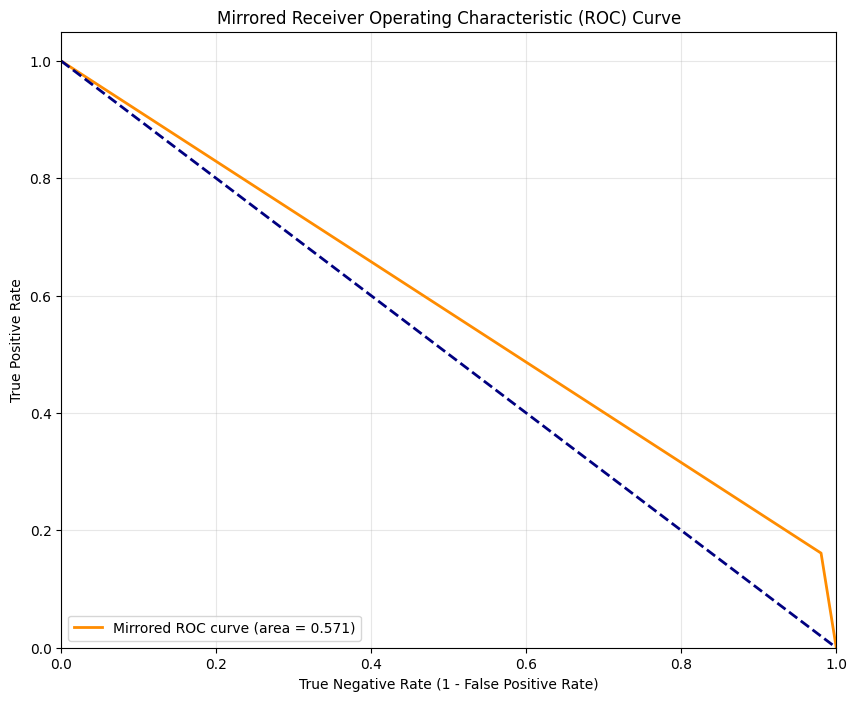

In [107]:
# Evaluate metrics

# [[True Negative, False Positive],
#  [False Negative, True Positive]]
conf_matrix = confusion_matrix(y_test, pred_test)
conf_matrix_dict = {
    "TN": conf_matrix[0][0],
    "FP": conf_matrix[0][1],
    "FN": conf_matrix[1][0],
    "TP": conf_matrix[1][1]
}

classification_report_dict = classification_report(y_test, pred_test, output_dict=True)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
roc_auc = auc(fpr, tpr)

tnr = 1 - fpr

plt.figure(figsize=(10, 8))

plt.plot(tnr, tpr, color='darkorange', lw=2, 
         label=f'Mirrored ROC curve (area = {roc_auc:.3f})')

# Plot diagonal line (represents random classifier)
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('True Negative Rate (1 - False Positive Rate)')
plt.ylabel('True Positive Rate')
plt.title('Mirrored Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower left")

# Display the plot
plt.grid(alpha=0.3)

plt.savefig("LogReg_ROC_Curve.png")

In [108]:
experiment_name = "LogReg_Training"
training_run_name = "LogReg_Training"

mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name=training_run_name):
    mlflow.log_param("undersampler_sampling_strategy", undersampler.sampling_strategy)
    mlflow.log_param("classifier_max_iter", classifier.max_iter)

    mlflow.log_dict(conf_matrix_dict, "confusion_matrix.json")
    mlflow.log_dict(classification_report_dict, "classification_report.json")

    mlflow.log_artifact("LogReg_ROC_Curve.png")

    mlflow.sklearn.log_model(grid_search.best_estimator_, "pipeline_LogReg")

2025/04/21 11:58:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogReg_Training at: https://dagshub.com/b3tameche/kaggle-fraud-detection.mlflow/#/experiments/1/runs/e5825473bac74a448fa8e2d1d5b4378b
🧪 View experiment at: https://dagshub.com/b3tameche/kaggle-fraud-detection.mlflow/#/experiments/1
